In [3]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt

In [4]:
data_file = "/media/data/projects/crophisto/data.npy"
data = np.load(data_file)
y = data[:, 8]
X = data[:, 0:8]


In [5]:
sample_size = 20000
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=0)

In [6]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [7]:
X_test.shape
y_test.shape

100/29

3.4482758620689653

In [8]:
np.unique(data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int8)

Mean support: 741, mean_frequency: 3.70%
Min support: 111, min_frequency: 0.56%
[4326  359  507 3158  838   11 3067 1205   40   93  123  445  518    8
   64  240   65   30   67   81   36 2440  903  108  569  699]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27]


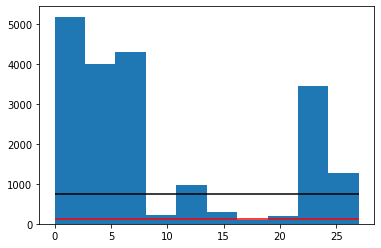

In [9]:
# find categories with less that min_size
num_categories = len(np.unique(y_test))
mean_frequency = (100/num_categories)/100 # porc
mean_support = round(sample_size * mean_frequency)
min_frequency = mean_frequency * 0.15
min_support = round(sample_size * min_frequency)
round(min_support)
print("Mean support: {}, mean_frequency: {:.2%}".format(mean_support, mean_frequency))
print("Min support: {}, min_frequency: {:.2%}".format(min_support, min_frequency))

# find categories under represented
categories = np.sort(np.unique(y_test))
freq, bins = np.histogram(y_test, bins=categories)

print (freq)
print(bins)
plt.hist(y_test)
plt.hlines(mean_support,0,27)
plt.hlines(min_support,0,27, colors="r")


In [10]:
under_categories = (freq<min_support).nonzero()[0]

under_categories
print(freq)
print(min_support)

[4326  359  507 3158  838   11 3067 1205   40   93  123  445  518    8
   64  240   65   30   67   81   36 2440  903  108  569  699]
111


In [11]:
needed = (freq-min_support)
needed
needed[needed >0] = 0
needed = -1*needed
print(needed)

print(categories)

[  0   0   0   0   0 100   0   0  71  18   0   0   0 103  47   0  46  81
  44  30  75   0   0   3   0   0]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27]


In [21]:
needed = (freq-min_support)
needed
needed[needed >0] = 0
needed = -1*needed
print("Initial dataset shape: {} ".format(X.shape))
y = y_test.copy()
X = X_test.copy()

for cat_index, cat_needed in enumerate(needed):
    if cat_needed == 0:
        continue
    print("Adding {} samples for category {}".format(cat_needed, cat_index))
    cat_mask = (y_train == categories[cat_index])

    bound = min(cat_needed, len(cat_mask == True))
    cat_y = y_train[cat_mask][:bound]
    y = np.hstack([y,cat_y])

    cat_X = X_train[cat_mask,:][:bound,:]
    X = np.vstack([X,cat_X])

dataset = np.hstack([X, y.reshape(-1,1)])

print("Final dataset shape: {}".format(dataset.shape))

np.save("../resources/data_sampled", dataset)


Initial dataset shape: (20003, 8) 
Adding 100 samples for category 5
Adding 71 samples for category 8
Adding 18 samples for category 9
Adding 103 samples for category 13
Adding 47 samples for category 14
Adding 46 samples for category 16
Adding 81 samples for category 17
Adding 44 samples for category 18
Adding 30 samples for category 19
Adding 75 samples for category 20
Adding 3 samples for category 23
Final dataset shape: (20618, 9)


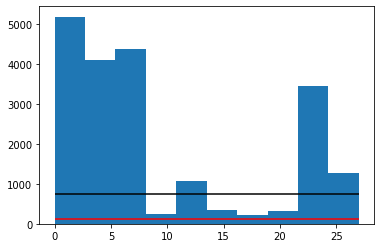

In [24]:
plt.hist(y)
plt.hlines(mean_support,0,27)
plt.hlines(min_support,0,27, colors="r")